In [ ]:
# 12 month moving average
df['Average'] = df['Last'].rolling(12).mean()

In [ ]:
# plot the data and MA
import plotly.express as px
fig = px.line(df, x="Date", y=["Last", "Average"], template = 'plotly_dark')
fig.show()

In [ ]:
df[['Last', 'Average']].describe()

In [ ]:
# month_counts = df['Month'].value_counts().astype(str)
# month_counts

## Split Data

In [ ]:

# # split data into train-test set
# train = df[df['Year'] <= 2023]
# test = df[df['Year'] > 2023]


# Memisahkan data menjadi train dan test
train = df.iloc[:-7, :]
test = df.iloc[-7:, :]

# check shape
train.shape, test.shape

# Model: SES
Simple Exponeial Smoohing

In [ ]:

from statsmodels.tsa.api import SimpleExpSmoothing
import plotly.express as px

y_hat_avg = test.copy()

#fit the model
fit2 = SimpleExpSmoothing(np.asarray(train['Last'])).fit(smoothing_level=0.8,optimized=False)

#forecast
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))

#Append train, test and forecast results
train['Name'] ='Train'
test['Name'] = 'Test'
x = train.append(test)
y = pd.DataFrame(y_hat_avg['SES'])
y['Name'] = 'SES'
y.rename(columns ={'SES':'Last'}, inplace = True )
z= x.append(y)
# Menyusun DataFrame dengan indeks waktu menggunakan 'Month' dan 'Year'
z['Date'] = df['Date']  
z = z.set_index('Date')

# Membuat plot dengan sumbu x yang menampilkan keterangan bulan dan tahun
fig = px.line(z, x=z.index, y="Last", color='Name', template = 'plotly_dark')
fig.update_xaxes(
    tickformat="%b %Y",  
    tickangle=45,         
    tickmode='auto',
    title_text='Month'
)
fig.show()



In [ ]:
#calculate root mean squared error
rms = sqrt(mean_squared_error(test['Last'], y_hat_avg.SES))
print('RMSE of Simple Exponential Smoothing: ', rms)

# MAPE
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(test['Last'], y_hat_avg.SES)
print('MAPE of Simple Exponential Smoothing: ', mape)

# Model: HoltWinter

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing
y_hat_avg = test.copy()

#Fit the model
fit2 = ExponentialSmoothing(np.asarray(train['Last']),trend='add', seasonal='add', seasonal_periods=12,damped=False).fit()

#Forecast
y_hat_avg['HoltWinter'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))

#Append train, test and forecast for visualization
train['Name'] ='Train'
test['Name'] = 'Test'
x = train.append(test)
y = pd.DataFrame(y_hat_avg['HoltWinter'])
y['Name'] = 'HoltWinter'
y.rename(columns ={'HoltWinter':'Last'}, inplace = True )
z= x.append(y)
z['Date'] = df['Date']  
z = z.set_index('Date')

# Membuat plot dengan sumbu x yang menampilkan keterangan bulan dan tahun
fig = px.line(z, x=z.index, y="Last", color='Name', template = 'plotly_dark')
fig.update_xaxes(
    tickformat="%b %Y",  
    tickangle=45,         
    tickmode='auto',
    title_text='Month'
)
fig.show()



In [ ]:

#RMSe
rms = sqrt(mean_squared_error(test['Last'], y_hat_avg.HoltWinter))
print('RMSE of HoltWinter Model:', rms)

#R2
r2 = r2_score(test['Last'], y_hat_avg.HoltWinter)
print('R-squared of HoltWinter Model:', r2)    

#MAPE
mape = mean_absolute_percentage_error(test['Last'], y_hat_avg.HoltWinter)
print('MAPE of HoltWinter Model: ', mape)

# Model SARIMAX

In [ ]:
import statsmodels.api as sm
model1=sm.tsa.statespace.SARIMAX(np.asarray(train['Last']),order=(1, 1, 1),seasonal_order=(1,1,1,12))

results=model1.fit()
results.summary()

# Import Packages & Data 

In [ ]:
#Forecast
y_hat_avg['sarimax'] = results.forecast(len(test))
plt.figure(figsize=(16,8))

#Append train, test and forecast for visualization
train['Name'] ='Train'
test['Name'] = 'Test'
x = train.append(test)
y = pd.DataFrame(y_hat_avg['sarimax'])
y['Name'] = 'SARIMAX'
y.rename(columns ={'sarimax':'Last'}, inplace = True )
z= x.append(y)
z['Date'] = df['Date']  
z = z.set_index('Date')

# Membuat plot dengan sumbu x yang menampilkan keterangan bulan dan tahun
fig = px.line(z, x=z.index, y="Last", color='Name', template = 'plotly_dark')
fig.update_xaxes(
    tickformat="%b %Y",  
    tickangle=45,         
    tickmode='auto',
    title_text='Month'
)
fig.show()

In [ ]:
#Check accuracy
rms = sqrt(mean_squared_error(test['Last'], y_hat_avg.sarimax))
print('RMSE of SARIMAX Model:', rms)

#r2
r2 = r2_score(test['Last'], y_hat_avg.sarimax)
print('R-squared of SARIMAX Model:', r2)

#MAPE
mape = mean_absolute_percentage_error(test['Last'], y_hat_avg.sarimax)
print('MAPE of SARIMAX Model: ', mape)


# Model: Stacked LSTM

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


# Preprocessing: Scaling the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Last']])
test_scaled = scaler.transform(test[['Last']])

# Function to create time series data for LSTM
def create_lstm_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset)-time_steps+1):
        a = dataset[i:(i+time_steps), 0]
        X.append(a)
        y.append(dataset[i + time_steps - 1, 0])
    return np.array(X), np.array(y)


# Set the time steps
time_steps = 2

# Create time series dataset for LSTM
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], time_steps, 1))


# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Predict on the test set
y_hat_lstm_scaled = model.predict(X_test)

# Inverse transform the scaled predictions
y_hat_lstm = scaler.inverse_transform(np.reshape(y_hat_lstm_scaled, (len(y_hat_lstm_scaled), 1)))

# Create DataFrame for LSTM forecast
y_hat_avg['LSTM'] = np.nan
y_hat_avg['LSTM'].iloc[time_steps-1:len(test)+time_steps-1] = y_hat_lstm.flatten()

# Append train, test, and forecast for visualization
x = train.append(test)
y = pd.DataFrame(y_hat_avg[['LSTM']])
y['Name'] = 'LSTM'
y.rename(columns={'LSTM': 'Last'}, inplace=True)
z = x.append(y)
z['Date'] = df['Date']
z = z.set_index('Date')

# Create plot with x-axis showing month and year
fig = px.line(z, x=z.index, y="Last", color='Name', template='plotly_dark')
fig.update_xaxes(
    tickformat="%b %Y",
    tickangle=45,
    tickmode='auto',
    title_text='Month'
)
fig.show()



In [173]:

test_values = test['Last'].dropna()
predicted_values = y_hat_avg['LSTM'].dropna()


test_values = test_values[test_values.index.isin(predicted_values.index)]
predicted_values = predicted_values[predicted_values.index.isin(test_values.index)]


rms = sqrt(mean_squared_error(test_values, predicted_values))
print('RMSE of LSTM Model:', rms)

r2 = r2_score(test_values, predicted_values)
print('R-squared of LSTM Model:', r2)

#MAPE
mape = mean_absolute_percentage_error(test_values, predicted_values)
print('MAPE of LSTM Model: ', mape)

RMSE of LSTM Model: 8.493025871313645
R-squared of LSTM Model: -0.09668504202901329
MAPE of LSTM Model:  0.04705843224072578


In [174]:
 y_hat_avg

,Date,Last,Month,Year,time_interval,diff,Average,Name,HoltWinter,sarimax,LSTM
178,2023-10-27,135.20,10,2023,28 days,-24.90,212.916667,Test,160.571284,163.174713,NaN
179,2023-11-24,122.00,11,2023,28 days,-13.20,193.966667,Test,127.351489,123.853697,130.323639
180,2023-12-29,146.40,12,2023,35 days,24.40,172.487500,Test,154.083434,146.271167,129.536911
181,2024-01-26,130.75,1,2024,28 days,-15.65,153.541667,Test,160.573011,159.317183,139.138565
182,2024-02-23,126.25,2,2024,28 days,-4.50,146.629167,Test,126.455399,129.541301,128.968369
183,2024-03-28,125.25,3,2024,34 days,-1.00,142.295833,Test,142.343315,155.048156,126.158813
184,2024-04-26,124.70,4,2024,29 days,-0.55,136.879167,Test,143.020420,155.436941,125.447464


# Model: XGBoost 

In [175]:
import xgboost as xgb

In [176]:
# Read the CSV file
df = pd.read_csv('historical-prices-01-12-2024.csv', sep=',')

# Use a try-except block to handle the conversion and handle non-date strings
try:
    # Attempt to convert 'ExpDate' to datetime with the specified format
    df['Exp Date'] = pd.to_datetime(df['Exp Date'], format='%d/%m/%Y')
except ValueError:
    # If the above fails, handle non-date strings or use a different format
    # You might need to customize this part based on the actual content of your data
    df['Exp Date'] = pd.to_datetime(df['Exp Date'], errors='coerce')

# Set the cleaned 'ExpDate' column as the index
df = df.set_index('Exp Date')

# Display the DataFrame
df.head()

,Symbol,Contract Name,Last,52W High,52W High Date,52W Low,52W Low Date,52W %Chg,Time
Exp Date,,,,,,,,,
2008-12-24,LQZ08,ICE NewCastle Coal December 2008 Futures,77.95,78.00,2008-12-17,72.30,2008-12-05,+7.81%,2008-12-24
2009-01-30,LQF09,ICE NewCastle Coal January 2009 Futures,82.60,83.50,2009-01-16,68.15,2008-12-05,+21.20%,2009-01-30
2009-02-27,LQG09,ICE NewCastle Coal February 2009 Futures,72.35,80.60,2009-01-06,67.65,2008-12-05,+6.95%,2009-02-27
2009-03-27,LQH09,ICE NewCastle Coal March 2009 Futures,61.50,79.85,2009-01-06,61.35,2009-03-06,-9.09%,2009-03-27
2009-04-24,LQJ09,ICE NewCastle Coal April 2009 Futures,62.35,79.85,2009-01-06,58.15,2009-03-16,-7.97%,2009-04-24


In [177]:
df = df.dropna()
df = df.drop(columns="Time")
df = df.drop(columns="Symbol")
df = df.drop(columns="Contract Name")
df = df.drop(columns="52W High")
df = df.drop(columns="52W High Date")
df = df.drop(columns="52W Low")
df = df.drop(columns="52W Low Date")
df = df.drop(columns="52W %Chg")


In [178]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.Last.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.256024
p-value: 0.016962


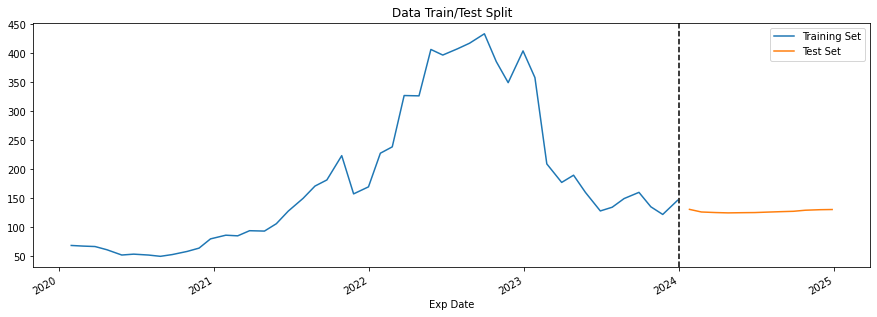

In [179]:
# @title Train/Test Split
train = df.loc[(df.index >= '2020') & (df.index < '2024')]
test = df.loc[(df.index >= '2024') & (df.index < '2025')]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2024-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [180]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [181]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Last'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [182]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:216.70869	validation_1-rmse:125.22749
[100]	validation_0-rmse:93.09094	validation_1-rmse:30.92803


c:\Users\ratun\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning:

[08:59:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[192]	validation_0-rmse:45.94354	validation_1-rmse:27.95685


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

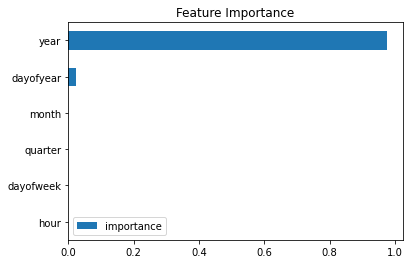

In [183]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

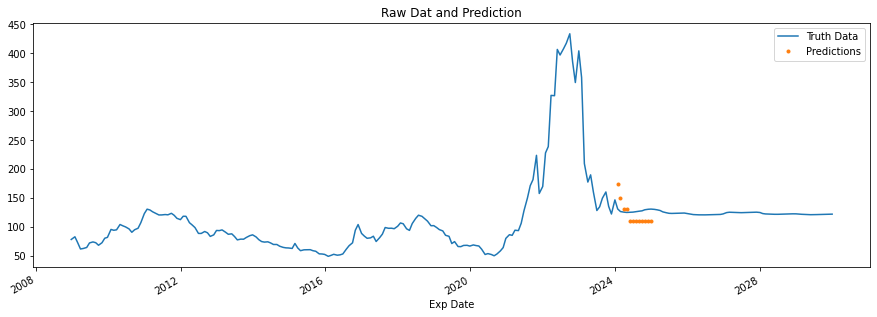

In [184]:
# @title Forecast on test
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Last']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

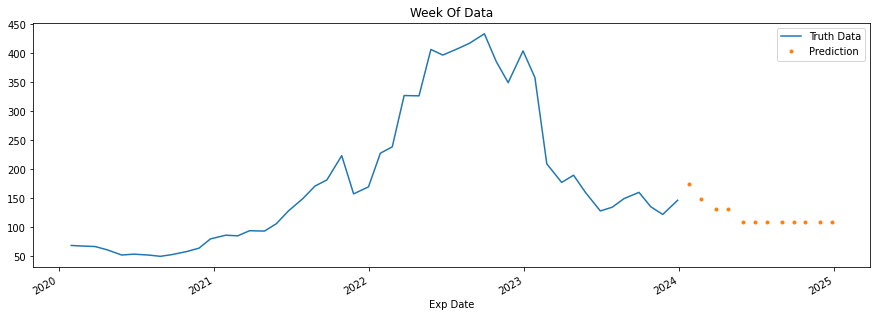

In [185]:
ax = df.loc[(df.index > '2020') & (df.index < '2024')]['Last'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index >= '2024') & (df.index < '2025')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [186]:
# @title RMSE
score = np.sqrt(mean_squared_error(test['Last'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 20.86


In [187]:
# @title Calculate Error
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2024-01-26    43.255966
2024-02-23    22.852615
2024-12-27    21.399094
2024-11-29    21.099094
2024-10-25    20.199094
2024-09-27    18.349094
2024-08-30    17.749094
2024-07-26    16.899094
2024-06-28    16.149094
2024-05-31    15.949094
Name: error, dtype: float64

# Split decomposed data

In [188]:
del trainu

NameError: name 'trainu' is not defined